<a href="https://www.kaggle.com/code/jesusgraterol/bitcoin-spot-order-book?scriptVersionId=136773416" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bitcoin Spot Order Book

When coding automated trading systems, it is essential to have a deep understanding  of how trades are filled and how the price is affected by the existing liquidity (Bids & Asks).

This notebook will download the current order book state from a Bitcoin Exchange, process the data, identify the liquidity peaks based on their intensity and based on the results of the analysis, determine which side (bids or asks) is dominating the market.

In [1]:
##################
## Dependencies ##
##################


from typing import Union, Dict, List, Tuple, TypedDict, Literal
from collections import Counter
from requests import get
from json import loads
from time import time
from numpy import mean, median, min, max
from pandas import DataFrame, Series
import utilities as utils
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(7, 4)})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.6 MB/s eta 0:00:00


In [2]:
###########
## Types ##
###########


# An order is comprised by bids (buy orders) and asks (sell orders)
IOrderBookSideID = Literal["bids", "asks"]

# Raw Order Book
# The order book state that will be used by this notebook comes from 
# Binance's Spot API.
IRawOrderBookLevel = List[str] # 0 = Price, 1 = Quantity
class IRawOrderBook(TypedDict):
    # Exchange internal value
    lastUpdateId: int
        
    # The list of existing bids and asks
    bids: List[IRawOrderBookLevel]
    asks: List[IRawOrderBookLevel]
    

# Processed Order Book
# Once the raw order book is downloaded and initialized, it is procesed
# for further interactions.
class IOrderBookLevel(TypedDict):
    # The price of the level
    price: int
    
    # The BTC Liquidity within the level
    quantity: float

        
# Order Book Intensity Peaks
# Once the data is processed, the peaks are identified and listed
# based on their intensity. 
# The intensity's purpose is to easily show price levels with
# significant liquidity.
IOrderBookLevelIntensity = Literal[1, 2, 3, 4]
class IOrderBookIntensityPeaks(TypedDict):
    x: List[float]
    y: List[IOrderBookLevelIntensity]


# The configuration dictionary used to hold user input to prevent/limit the 
# editing of the source code.
class IConfig(TypedDict):
    raw_data_endpoint: str
    max_distance_from_price: float
    

In [3]:
######################
## Helper Functions ##
######################


def plot_liquidity_bar_chart(
    x: Union[Series, List[Union[int, float]]], 
    y: Union[Series, List[Union[int, float]]], 
    color: str = "green", 
    figsize: Tuple[int, int] = (7, 3),
    bar_width: int = 3,
    ylabel: str = "BTC Quantity",
    xlabel: str = "Price",
) -> None:
    """Plots a simple bar chart used to display orders' quantity
    by price level.
    
    Args:
        x: Series
        y: Series
            The values that will be plotted.
        color: str
            The bars' color
        figsize: Tuple[int, int]
            The size of the chart
        bar_width: int
            The width that will be used to plot each bar
        ylabel: str
        xlabel: str
            The labels for both axis
    """
    fig = plt.figure(figsize=figsize)
    plt.bar(x, y, width=bar_width, color=color)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    

def plot_depth_chart(bids: DataFrame, asks: DataFrame) -> None:
    """Plots the order book's depth chart for both, bids and asks.
    
    Args:
        bids: DataFrame
        asks: DataFrame
            The dfs containing all quantities and prices for both sides
    """
    fig, ax = plt.subplots()
    ax.set_title(f"BTCUSDT Order Book - Depth Chart")
    sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=bids, color="green", ax=ax)
    sns.ecdfplot(x="price", weights="quantity", stat="count", data=asks, color="red", ax=ax)
    ax.set_xlabel("Price")
    ax.set_ylabel("BTC Quantity")
    print()
    
    

# Configuration

In [4]:
CONFIG: IConfig = {
    # Raw Data Endpoint: Due to regulation, Binance was forced to block requests 
    # originated from US IPs. Since some of Kaggles' containers are hosted in the 
    # US, I was forced to download a raw request and upload it else where, so it 
    # can be used in this notebook. The data used can be found at: 
    # https://api.binance.com/api/v3/depth?symbol=BTCUSDT&limit=5000
    
    # snap_30_06_2023-10_44am
    #"raw_data_endpoint": "https://firebasestorage.googleapis.com/v0/b/projectplutus-dev.appspot.com/o/public%2Fkaggle_mocks%2Fspot_order_book%2Fsnap_30_06_2023-10_44am.json?alt=media&token=0ad380ac-4924-4bdc-a211-52e061377d0b",
    
    # snap_30_06_2023-11_21am
    #"raw_data_endpoint": "https://firebasestorage.googleapis.com/v0/b/projectplutus-dev.appspot.com/o/public%2Fkaggle_mocks%2Fspot_order_book%2Fsnap_30_06_2023-11_21am.json?alt=media&token=fa56dc7f-f7a9-421f-a34a-16739174678d",
    
    # snap_03_07_2023_10_10am
    #"raw_data_endpoint": "https://firebasestorage.googleapis.com/v0/b/projectplutus-dev.appspot.com/o/public%2Fkaggle_mocks%2Fspot_order_book%2Fsnap_03_07_2023_10_10am.json?alt=media&token=f02b7fa8-21ef-41af-9c31-95aed2954707",
    
    # snap_03_07_2023_02_40pm
    "raw_data_endpoint": "https://firebasestorage.googleapis.com/v0/b/projectplutus-dev.appspot.com/o/public%2Fkaggle_mocks%2Fspot_order_book%2Fsnap_03_07_2023_02_40pm.json?alt=media&token=06b36cad-b929-4b0c-8a71-4c520e89049e",
    
    # Exchange platforms allow users to create buy and/or sell orders at any price, 
    # as the value of any asset is driven by offer and demand. While this is the 
    # foundation of strong markets, it allows "bad actors" to create large orders 
    # with the only purpose of scaring other traders, as they don't really want them 
    # to be fulfilled. These large orders can be considered to be outliers, as they 
    # will be cancelled when the price approaches them. In order to handle this situation, 
    # when processing the order book, we will just take the orders that are within the 
    # max_distance_from_price% range.
    "max_distance_from_price": 0.35
}

# Data Extraction

In [5]:
# Retrieve the order book at the latest state
req = get(CONFIG["raw_data_endpoint"])
if req.status_code != 200:
  print(req)
  raise RuntimeError(f"The Exchange API returned an invalid status code. Needs {200}, Received {req.status_code}")
    
# Initialize the book
raw_book: IRawOrderBook = loads(req.content)
if not isinstance(raw_book.get("bids"), list) or not isinstance(raw_book.get("asks"), list):
  print(raw_book)
  raise RuntimeError("The Exchange API returned an invalid order book dictionary.")

In [6]:
# Create the raw books' bids and asks dfs
raw_bids_df: DataFrame = DataFrame(raw_book["bids"], columns=["price", "quantity"], dtype=float)
raw_asks_df: DataFrame = DataFrame(raw_book["asks"], columns=["price", "quantity"], dtype=float)

RAW BIDS (385.79735999999997BTC)

              price     quantity
count   5000.000000  5000.000000
mean   30773.462278     0.077159
std      115.961846     0.743916
min    30591.650000     0.000330
25%    30677.120000     0.000460
50%    30761.520000     0.000970
75%    30860.775000     0.003442
max    31019.760000    24.348610


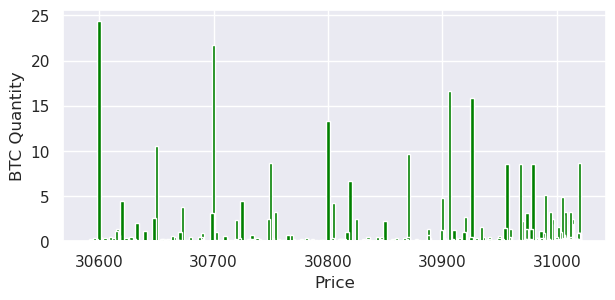

In [7]:
# Display a summary of the raw bids
print(f"RAW BIDS ({utils.currency(raw_bids_df['quantity'].sum(), 'BTC')})\n")
print(raw_bids_df.describe())
plot_liquidity_bar_chart(raw_bids_df["price"], raw_bids_df["quantity"])

RAW ASKS (622.2378BTC)

              price     quantity
count   5000.000000  5000.000000
mean   31207.005416     0.124448
std       95.920933     2.109954
min    31019.770000     0.000320
25%    31126.172500     0.000490
50%    31210.090000     0.001200
75%    31288.422500     0.004800
max    31368.600000   127.782100


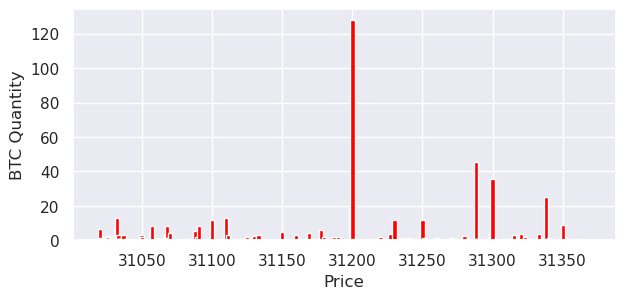

In [8]:
# Display a summary of the raw asks
print(f"RAW ASKS ({utils.currency(raw_asks_df['quantity'].sum(), 'BTC')})\n")
print(raw_asks_df.describe())
plot_liquidity_bar_chart(raw_asks_df["price"], raw_asks_df["quantity"], color="red")

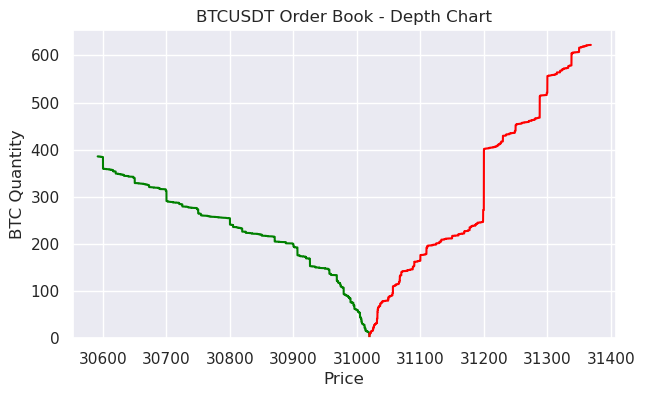

In [9]:
# Display the depth chart
plot_depth_chart(raw_bids_df, raw_asks_df)

# Data Processing

The raw order book state groups the levels by price with decimals. In order to simplify further interactions, the levels will be grouped by units instead.

In [10]:
# Init the price range that will be used
current_price: float = mean([raw_bids_df.iloc[0]["price"], raw_asks_df.iloc[0]["price"]])
min_price: float = utils.alter_number_by_percentage(current_price, -(CONFIG["max_distance_from_price"]))
max_price: float = utils.alter_number_by_percentage(current_price, CONFIG["max_distance_from_price"])

print("PRICE RANGE")
print(f"Current: {utils.currency(current_price)}")
print(f"Minimum: {utils.currency(min_price)}")
print(f"Maximum: {utils.currency(max_price)}")

PRICE RANGE
Current: 31,019.765$
Minimum: 30,911.2$
Maximum: 31,128.33$


In [11]:
def process_levels_for_side(levels: List[IRawOrderBookLevel], side: IOrderBookSideID) -> List[IOrderBookLevel]:
    """Given a list of levels for a side, it will process them and
    return the new list
    
    Args:
        levels: List[IRawOrderBookLevel]
            The list of levels for the side
        side: IOrderBookSideID
            The order that should be applied to the list. Bids are
            ordered from high to low and asks from low to high
            
    Returns:
        List[IOrderBookLevel]
    """
    # Init the dict that will keep track of whole prices & quantities
    side_levels: Dict[int, float] = {}

    # Iterate over each item
    for level in levels:
        # Init the key of the item (whole price)
        level_key: int = int(float(level[0]))
            
        # Only proceed if the price is within the range
        if (side == "bids" and level_key >= min_price) or (side == "asks" and level_key <= max_price):
            # Init the quantity
            qty: float = float(level[1])

            # Add or update the item
            side_levels[level_key] = qty if side_levels.get(level_key) is None else side_levels[level_key] + qty

    # Build the list of items
    levels: List[IOrderBookLevel] = [{"price": key, "quantity": value} for key, value in side_levels.items()]

    # Finally, return the list or sorted book items
    return sorted(levels, key=lambda x: x["price"], reverse=True if side == "bids" else False)

In [12]:
# Init the processed list of book items
processed_bids: List[IOrderBookLevel] = process_levels_for_side(raw_book["bids"], "bids")
processed_asks: List[IOrderBookLevel] = process_levels_for_side(raw_book["asks"], "asks")
print(f"Processed Bids {len(processed_bids)}")
print(f"Sample: {processed_bids[0]}")
print(f"\nProcessed Asks {len(processed_asks)}")
print(f"Sample: {processed_asks[0]}")

Processed Bids 108
Sample: {'price': 31019, 'quantity': 12.513030000000002}

Processed Asks 110
Sample: {'price': 31019, 'quantity': 8.28973}


In [13]:
# Initialize the dfs in order to analyze them
bids_df: DataFrame = DataFrame(processed_bids)
asks_df: DataFrame = DataFrame(processed_asks)

PROCESSED BIDS (173.98386000000002BTC)

             price    quantity
count    108.00000  108.000000
mean   30965.50000    1.610962
std       31.32092    3.122891
min    30912.00000    0.000550
25%    30938.75000    0.036100
50%    30965.50000    0.389650
75%    30992.25000    1.299735
max    31019.00000   15.849960


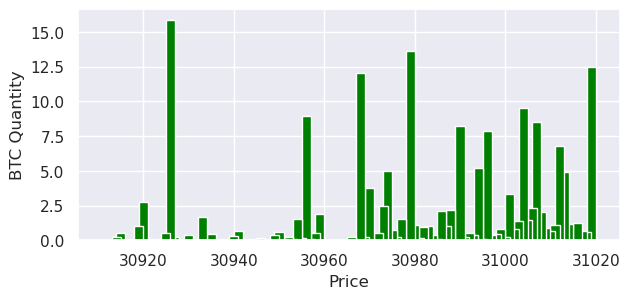

In [14]:
# Display a summary of the processed bids
print(f"PROCESSED BIDS ({utils.currency(bids_df['quantity'].sum(), 'BTC')})\n")
print(bids_df.describe())
plot_liquidity_bar_chart(bids_df["price"], bids_df["quantity"], bar_width=2)

PROCESSED ASKS (201.7323BTC)

              price    quantity
count    110.000000  110.000000
mean   31073.500000    1.833930
std       31.898276    3.590544
min    31019.000000    0.009410
25%    31046.250000    0.082388
50%    31073.500000    0.368460
75%    31100.750000    1.819700
max    31128.000000   18.889900


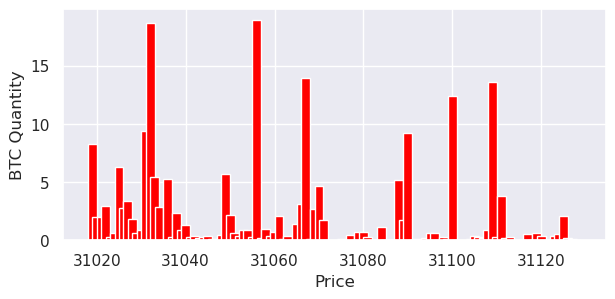

In [15]:
# Display a summary of the processed asks
print(f"PROCESSED ASKS ({utils.currency(asks_df['quantity'].sum(), 'BTC')})\n")
print(asks_df.describe())
plot_liquidity_bar_chart(asks_df["price"], asks_df["quantity"], color="red", bar_width=2)

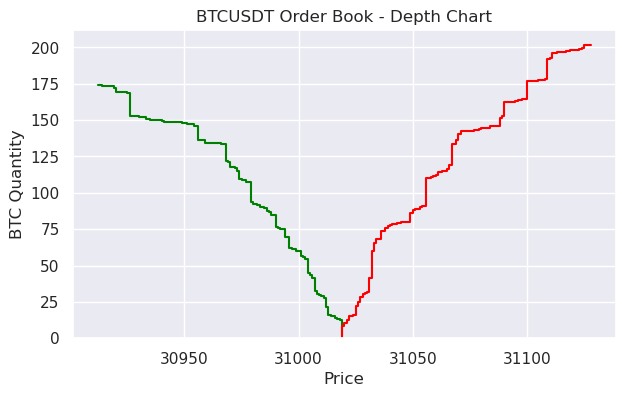

In [16]:
# Display the depth chart
plot_depth_chart(bids_df, asks_df)

# Liquidity Peaks

The following code will take care of analyzing the processed order book in order to identify all the bids and asks liquidity peaks (also known as buy/sell walls).

In [17]:
# Calculate the requirements that will be used to determine the 
# liquidity intensity of a price level

# Init the lists of quantities by side
bid_quantities: List[float] = bids_df["quantity"].tolist()
ask_quantities: List[float] = asks_df["quantity"].tolist()

# Put all the liquidities together
liquidities: List[float] = bid_quantities + ask_quantities
    
# Calculate the mean, min & max
liq_mean: float = mean(liquidities)
liq_min: float = min(liquidities)
liq_max: float = max(liquidities)

# Calculate the intensity requirements. Levels with liquidity smaller than
# requirement_low are considered to have very low intensity.
requirement_low: float = mean([liq_mean, liq_min])
requirement_high: float = mean([liq_mean, liq_max])
requirement_medium: float = mean([requirement_low, requirement_high])
print("INTENSITY REQUIREMENTS")
print(f"Low: {utils.currency(requirement_low, symbol=' BTC')}")
print(f"Medium: {utils.currency(requirement_medium, symbol=' BTC')}")
print(f"High: {utils.currency(requirement_high, symbol=' BTC')}")

INTENSITY REQUIREMENTS
Low: 0.8620093119266056 BTC
Medium: 5.584346811926606 BTC
High: 10.306684311926606 BTC


In [18]:
def calculate_intensity(quantity: float) -> IOrderBookLevelIntensity:
    """Calculates a level's intensity based on its liquidity and the
    requirements.
    
    Args:
        quantity: float
            The liquidity amount present in the price level.
            
    Returns:
        IOrderBookLevelIntensity
    """
    if quantity < requirement_low:
        return 1
    elif quantity >= requirement_low and quantity < requirement_medium:
        return 2
    elif quantity >= requirement_medium and quantity < requirement_high:
        return 3
    else:
        return 4
    

def build_intensity_peaks_for_side(side: IOrderBookSideID) -> IOrderBookIntensityPeaks:
    """Builds the peaks dict for all price levels.
    
    Args:
        side: IOrderBookSideID
            The order book side for which the peaks will be built.
            
    Returns:
        IOrderBookIntensityPeaks
    """
    # Init the peaks dict
    peaks: IOrderBookIntensityPeaks = { "x": [], "y": []}
        
    # Iterate over each level and determine its intensity based on the requirements
    for row in bids_df.to_records() if side == "bids" else asks_df.to_records():
        peaks["x"].append(row["price"])
        peaks["y"].append(calculate_intensity(row["quantity"]))
        
    # Finally, return the peaks dict
    return peaks

In [19]:
# Build the peaks for both sides
bid_peaks: IOrderBookIntensityPeaks = build_intensity_peaks_for_side("bids")
ask_peaks: IOrderBookIntensityPeaks = build_intensity_peaks_for_side("asks")

BID PEAKS
Counter({1: 72, 2: 26, 3: 6, 4: 4})


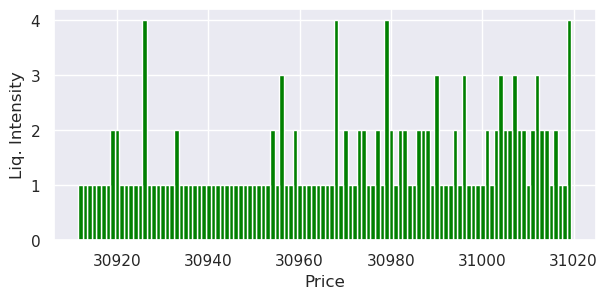

In [20]:
# Count the number of peaks found in the bids
bid_peaks_count = Counter(bid_peaks["y"])
print("BID PEAKS")
print(bid_peaks_count)
plot_liquidity_bar_chart(bid_peaks["x"], bid_peaks["y"], bar_width=1, ylabel="Liq. Intensity")

ASK PEAKS
Counter({1: 72, 2: 28, 3: 5, 4: 5})


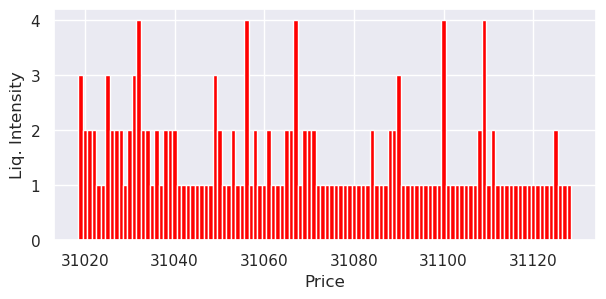

In [21]:
# Count the number of peaks found in the asks
ask_peaks_count = Counter(ask_peaks["y"])
print("ASK PEAKS")
print(ask_peaks_count)
plot_liquidity_bar_chart(ask_peaks["x"], ask_peaks["y"], bar_width=1, ylabel="Liq. Intensity", color="red")